In [61]:
import antiCPy
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.layers import LeakyReLU
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
import seaborn as sns
sns.set()

In [62]:
XAI = np.load("XAI_Finance.npy")
Names = np.load("Names.npy")
CorrMatrices = np.load("CorrMatricesTriangular.npy")
LabelNaiveOrdered = np.load("LabelNaiveOrdered.npy")
#OptimalXAI = np.load("OptimalXAIFeature.npy")
# now something different
OptimalXAI = np.load("XAI_modes.npy")
MedianLogical = np.load("MedianLogical.npy")
print(OptimalXAI, MedianLogical)
print(CorrMatrices[:, MedianLogical].shape)

[[ 0 11]
 [ 1 40]
 [ 2 37]
 [ 3 41]
 [ 4 16]
 [ 5 16]
 [ 6 14]
 [ 7 16]] [False False False False False False False False False False False False
 False False  True  True  True False False False False False False  True
 False False False False False False  True False False False False False
 False False False False False  True False False False False False False
 False False False False False False False]
(5251, 6)


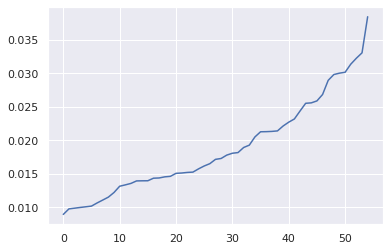

In [63]:
#plt.plot(np.sort(abs(XAI).mean(0)))
plt.plot(np.sort(np.median(abs(XAI),0)))

### Train NN with all relevant features

For this, we need one-hot encoded y

In [64]:
print(set(OptimalXAI[:,1]))
CM_Reduced = CorrMatrices[:,list(set(OptimalXAI[:,1]))]
print(CM_Reduced.shape)

# one hot encoded
encoded_Y = np_utils.to_categorical(LabelNaiveOrdered)

X_train, X_test, y_train, y_test = train_test_split(CM_Reduced, encoded_Y,
                                                    test_size=0.33, random_state=1)
print(encoded_Y)

# reverse the encoding via
# np.argmax(encoded_Y, 1)

{37, 40, 41, 11, 14, 16}
(5251, 6)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


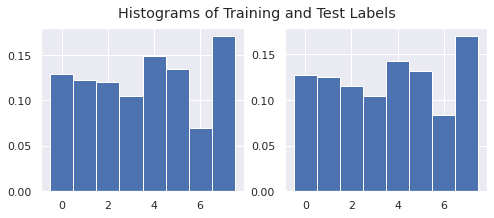

In [65]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(8, 3)
ax1.hist(np.argmax(y_train,1), density = True,
         bins = np.arange(-0.5, max(np.argmax(y_train,1))+1.5,1))
ax2.hist(np.argmax(y_test,1),density = True,
         bins = np.arange(-0.5, max(np.argmax(y_test,1))+1.5,1))
plt.suptitle("Histograms of Training and Test Labels")
plt.show()

In [66]:
n_In = CM_Reduced.shape[1]
num_classes = len(set(LabelNaiveOrdered))
print(n_In, num_classes)

model = keras.Sequential(
    [
        layers.Dense(units = 256, input_shape=(n_In,), activation = "selu"),
        layers.Dense(units=128, activation="relu"),
        layers.Dense(units=128, activation="relu"),
        layers.Dense(units=1024,
              activation=keras.layers.LeakyReLU(alpha=0.05)),
        layers.Dense(units=128,
              activation=keras.layers.LeakyReLU(alpha=0.01)),
        layers.Dropout(0.3),
        layers.Dense(units =num_classes, activation="softmax"),
    ]
)
#model.build(n_In)
model.summary()

6 8
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 256)               1792      
                                                                 
 dense_19 (Dense)            (None, 128)               32896     
                                                                 
 dense_20 (Dense)            (None, 128)               16512     
                                                                 
 dense_21 (Dense)            (None, 1024)              132096    
                                                                 
 dense_22 (Dense)            (None, 128)               131200    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_23 (Dense)            (None, 8)            

In [67]:
batch_size = 128
epochs = 100

model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(lr=0.0001),
              metrics=["accuracy"])

model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.5)

Epoch 1/100
14/14 [==============================] - 1s 17ms/step - loss: 2.0546 - accuracy: 0.2103 - val_loss: 2.0203 - val_accuracy: 0.2280
Epoch 2/100
14/14 [==============================] - 0s 6ms/step - loss: 1.9795 - accuracy: 0.2496 - val_loss: 1.9420 - val_accuracy: 0.2683
Epoch 3/100
14/14 [==============================] - 0s 7ms/step - loss: 1.8814 - accuracy: 0.3042 - val_loss: 1.8324 - val_accuracy: 0.3150
Epoch 4/100
14/14 [==============================] - 0s 6ms/step - loss: 1.7559 - accuracy: 0.3593 - val_loss: 1.6980 - val_accuracy: 0.3928
Epoch 5/100
14/14 [==============================] - 0s 6ms/step - loss: 1.6047 - accuracy: 0.4611 - val_loss: 1.5369 - val_accuracy: 0.5065
Epoch 6/100
14/14 [==============================] - 0s 7ms/step - loss: 1.4330 - accuracy: 0.5446 - val_loss: 1.3653 - val_accuracy: 0.5492
Epoch 7/100
14/14 [==============================] - 0s 6ms/step - loss: 1.2779 - accuracy: 0.5821 - val_loss: 1.2226 - val_accuracy: 0.5657
Epoch 8/100


In [68]:
y_hat = np.argmax(model.predict(X_test),1)
Accuracy_BestXAI = np.mean(y_hat == np.argmax(y_test,1))
print(Accuracy_BestXAI)

0.7864974033467974


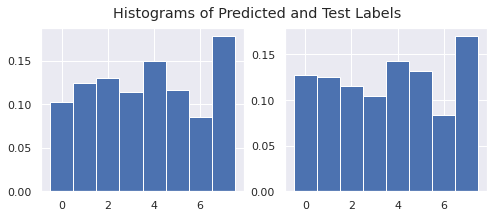

In [69]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(8, 3)
ax1.hist(y_hat, density = True,
         bins = np.arange(-0.5, max(y_hat)+1.5,1))
ax2.hist(np.argmax(y_test,1),density = True,
         bins = np.arange(-0.5, max(np.argmax(y_test,1))+1.5,1))
plt.suptitle("Histograms of Predicted and Test Labels")
plt.show()

### Comparison: best features according to Median XAI values

In [70]:


X_train, X_test, y_train, y_test = train_test_split(CorrMatrices[:, MedianLogical],
                                                    encoded_Y, test_size=0.33, random_state=1)


model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.5)

y_hat = np.argmax(model.predict(X_test),1)
Accuracy_BestMedianXAI = np.mean(y_hat == np.argmax(y_test,1))


Epoch 1/100
14/14 [==============================] - 0s 8ms/step - loss: 2.8582 - accuracy: 0.3468 - val_loss: 1.8597 - val_accuracy: 0.3712
Epoch 2/100
14/14 [==============================] - 0s 7ms/step - loss: 1.5004 - accuracy: 0.4588 - val_loss: 1.2876 - val_accuracy: 0.5065
Epoch 3/100
14/14 [==============================] - 0s 7ms/step - loss: 1.1735 - accuracy: 0.5514 - val_loss: 1.1392 - val_accuracy: 0.5514
Epoch 4/100
14/14 [==============================] - 0s 7ms/step - loss: 1.0756 - accuracy: 0.5890 - val_loss: 1.0512 - val_accuracy: 0.5947
Epoch 5/100
14/14 [==============================] - 0s 7ms/step - loss: 0.9816 - accuracy: 0.6259 - val_loss: 0.9933 - val_accuracy: 0.6157
Epoch 6/100
14/14 [==============================] - 0s 7ms/step - loss: 0.9305 - accuracy: 0.6464 - val_loss: 0.9478 - val_accuracy: 0.6265
Epoch 7/100
14/14 [==============================] - 0s 7ms/step - loss: 0.8833 - accuracy: 0.6686 - val_loss: 0.9194 - val_accuracy: 0.6407
Epoch 8/100
1

In [71]:
print(Accuracy_BestMedianXAI)

0.8003462204270052


### Now with some other features

In [72]:
def TestNN(seed = 1234):
    np.random.seed(seed)
    Index = np.random.choice(np.arange(XAI.shape[1]).astype("int"), # features to compare optimal XAI to
                     size = len(list(set(OptimalXAI[:,1]))),
                     replace = False)
    CM_Reduced = CorrMatrices[:,Index]
    X_train, X_test, y_train, y_test = train_test_split(CM_Reduced, encoded_Y,
                                                    test_size=0.33, random_state=1)
    model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.5,
          verbose=0)
    y_hat = np.argmax(model.predict(X_test),1)
    return(np.mean(y_hat == np.argmax(y_test,1)))

In [73]:
TestNN(54321)

0.7305251009809579

In [74]:
TestNN()

0.7345643392960185

In [75]:
Runs = 100
NN_comparison = np.zeros(Runs)

for i in range(Runs):
    s = np.random.choice(np.arange(10000).astype("int"),1)
    Test_Score = TestNN(s)
    print(i,s,Test_Score)
    NN_comparison[i] = Test_Score


0 [5206] 0.753606462781304
1 [8676] 0.760530871321408
2 [2446] 0.7841892671667628
3 [2594] 0.7836122331217542
4 [0] 0.7397576457010964
5 [7221] 0.8101557991921523
6 [6887] 0.79399884593191
7 [7580] 0.7599538372763993
8 [30] 0.7189844200807848
9 [7699] 0.6976341604154646
10 [4222] 0.7616849394114252
11 [6242] 0.7668782458165032
12 [1070] 0.8286208886324293
13 [6397] 0.762261973456434
14 [7177] 0.773802654356607
15 [2956] 0.7841892671667628
16 [395] 0.7524523946912868
17 [5141] 0.7432198499711483
18 [8748] 0.7864974033467974
19 [6897] 0.7714945181765724
20 [5977] 0.7928447778418927
21 [5705] 0.7761107905366417
22 [4016] 0.7749567224466244
23 [2914] 0.7449509521061742
24 [142] 0.7311021350259665
25 [657] 0.7201384881708021
26 [9479] 0.690132717830352
27 [4210] 0.7137911136757069
28 [8513] 0.7178303519907675
29 [9173] 0.7414887478361223
30 [9637] 0.688401615695326
31 [6801] 0.7501442585112522
32 [3333] 0.6912867859203693
33 [921] 0.7149451817657242
34 [1677] 0.7518753606462781
35 [5278] 0.

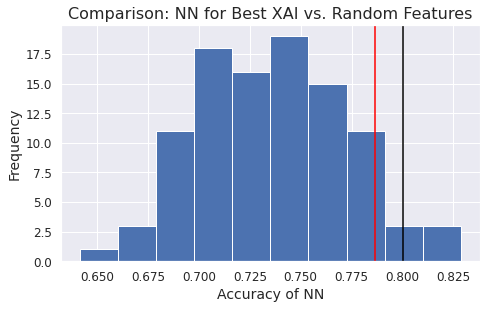

In [76]:
fig = plt.gcf()
fig.set_size_inches(7.5,4.35)
plt.hist(NN_comparison)
plt.axvline(Accuracy_BestXAI,
            c="red")
plt.axvline(Accuracy_BestMedianXAI,
            c="black")
plt.xlabel("Accuracy of NN",fontsize=14)
plt.ylabel("Frequency",fontsize=14)
plt.title("Comparison: NN for Best XAI vs. Random Features",
          fontsize = 16)s
plt.savefig("Comparison_RandomFeatures_vs_XAImode_100NN",dpi=600)
plt.show()

In [77]:
np.median(NN_comparison),np.mean(NN_comparison), Accuracy_BestXAI

(0.7362954414310444, 0.7360646278130409, 0.7864974033467974)